In [1]:
import numpy as np
from scipy import optimize as sp_optimize

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled

In [2]:
def sample_mixgauss(wk, sk, size):
    runif = np.random.uniform(0, 1, size = size)
    gcomp = np.digitize(runif, np.cumsum(wk))
    x = np.zeros(size)
    for i, gc in enumerate(gcomp):
        if sk[gc] > 0:
            x[i] = np.random.normal(0, sk[gc]) 
    return x

def NM_sample(mean, std = 1.0):
    p   = mean.shape[0]
    cov = np.eye(p) * std * std
    y   = np.random.multivariate_normal(mean, cov)
    return y

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

def softmax(x, base = np.exp(1)):
    if base is not None:
        beta = np.log(base)
        x = x * beta
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis = 0, keepdims = True)

def penalty_operator(z, wk, std, sk, dj):
    nm = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    tvar = (std * std) / dj
    lambdaj = - nm.logML - 0.5 * tvar * np.square(nm.logML_deriv)
    return lambdaj

def shrinkage_operator(nm):
    M        = nm.y + nm.yvar * nm.logML_deriv
    M_bgrad  = 1       + nm.yvar * nm.logML_deriv2
    M_wgrad  = nm.yvar.reshape(-1, 1) * nm.logML_deriv_wderiv
    M_s2grad = (nm.logML_deriv / nm._d) + (nm.yvar * nm.logML_deriv_s2deriv)
    return M, M_bgrad, M_wgrad, M_s2grad

def unshrink_b(b, std, wk, sk, dj, theta = None, max_iter = 100, tol = 1e-8):
    # this is the initial value of theta
    if theta is None:
        theta = np.zeros_like(b)
    # Newton-Raphson iteration
    for itr in range(max_iter):
        nmash = NormalMeansASHScaled(theta, std, wk, sk, d = dj)
        Mtheta, Mtheta_bgrad, _, _ = shrinkage_operator(nmash)
        theta_new = theta - (Mtheta - b) / Mtheta_bgrad
        diff = np.sum(np.square(theta_new - theta))
        theta = theta_new
        obj = np.sum(- nmash.logML - 0.5 * nmash.yvar * np.square(nmash.logML_deriv))
        print(obj)
        if diff <= tol:
            break
    return theta

def shrink_theta(z, std, wk, sk, dj):
    nmash = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    Mb = shrinkage_operator(nmash)[0]
    return Mb

def penalty_operator_lagrangian(z, wk, std, sk, dj, lgrng, b):
    Mt  = shrink_theta(z, std, wk, sk, dj)
    hwt = penalty_operator(z, wk, std, sk, dj)
    obj = np.sum(hwt) + np.sum(lgrng * (Mt - b))
    return obj

def penalty_operator_lagrangian_deriv(z, wk, std, sk, dj, lgrng, b):
    '''
    The Normal Means model
    '''
    nmash = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    '''
    gradient w.r.t lambda_j (lagrangian penalty)
    '''
    M, M_bgrad, M_wgrad, M_s2grad  = shrinkage_operator(nmash)
    dLdl = M - b
    '''
    gradient w.r.t wk (prior mixture coefficients)
    '''
    tvar  = (strue * strue) / dj
    v2_ld_ldwd = tvar.reshape(-1, 1) * nmash.logML_deriv.reshape(-1, 1) * nmash.logML_deriv_wderiv
    ## gradient of first term and second term of the lagrangian
    l1_wgrad = - nmash.logML_wderiv - v2_ld_ldwd
    l2_wgrad = lgrng.reshape(-1, 1) * M_wgrad
    dLdw = np.sum(l1_wgrad + l2_wgrad, axis = 0)
    '''
    gradient w.r.t theta
    '''
    l1_tgrad = - nmash.logML_deriv  - tvar * nmash.logML_deriv * nmash.logML_deriv2
    l2_tgrad = lgrng * (1 + tvar * nmash.logML_deriv2)
    dLdt = l1_tgrad + l2_tgrad
    return dLdl, dLdw, dLdt

def objective_numeric_lagrangian(params, std, sk, dj, b, p, k, softmax_base):
    zj = params[:p]
    lj = params[p:2*p]
    ak = params[2*p:]
    wk = softmax(ak, base = softmax_base)
    dLdl, dLdw, dLdt = penalty_operator_lagrangian_deriv(zj, wk, std, sk, dj, lj, b)
    akjac = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
    dLda = np.sum(dLdw * akjac, axis = 1)
    obj = np.sqrt(np.sum(np.square(dLdl)) + np.sum(np.square(dLda)) + np.sum(np.square(dLdt)))
    return obj

def objective_lagrangian(params, std, sk, dj, b, p, k, softmax_base):
    zj = params[:p]
    lj = params[p:2*p]
    ak = params[2*p:]
    wk = softmax(ak, base = softmax_base)
    obj = penalty_operator_lagrangian(zj, wk, std, sk, dj, lj, b)
    return obj

In [3]:
p = 500
k = 4
sparsity = 0.8
strue = 1.0

np.random.seed(100)
wtrue, sk = initialize_ash_prior(k, sparsity = sparsity)
#sk = np.logspace(-1, k-2, k)
btrue = sample_mixgauss(wtrue, sk, p)
y = NM_sample(btrue, std = strue)
dj = np.ones(p)
ztrue = unshrink_b(btrue, strue, wtrue, sk, dj)

468.46016540925973
3722.7427468655596
497.3110204099118
978.003737958441
513.3695298285595
837.4452044736151
526.8737312555584
763.1424181256866
536.9002485304591
709.4215958151581
539.9800422077848
683.138396205572
543.0124182317721
644.6391083673125
547.7795690233634
622.9580304777107
549.3511727007262
602.5051189714745
552.2957403012516
574.7382937026529
558.2379447490023
558.174684113154
558.0645816859619
558.0629314174837


In [4]:
#z = np.random.rand(p)
#z = unshrink_b(btrue, strue, wtrue, sk, dj)
z = ztrue.copy()
softmax_base = np.exp(1)
#winit, _ = initialize_ash_prior(k)
winit    = wtrue.copy()
akinit   = np.log(winit + 1e-8) / np.log(softmax_base)
#akinit[0] = 5
lgrng    = np.ones(btrue.shape[0]) * 10
wk       = softmax(akinit, base = softmax_base)

initparams = np.concatenate([z, lgrng, akinit])
cg_min = sp_optimize.minimize(objective_numeric_lagrangian, initparams,
                              args = (strue, sk, dj, btrue, p, k, softmax_base),
                              method = 'CG',
                              options = {'disp': True, 'maxiter': 100, 'return_all': True}
                             )

         Current function value: 3.766121
         Iterations: 100
         Function evaluations: 272355
         Gradient evaluations: 271


True w: [0.8        0.06666667 0.06666667 0.06666667]
Est. w:  [9.87229071e-01 1.30459063e-03 1.14663386e-02 4.52108143e-11]
Est. Lagrangian (for non-zero b): 
[ 9.79608365 10.01525369  9.78924101  7.45799468 10.00871436  9.82196562
  9.81674008  9.8226266   9.50012618  9.93741333  9.41025259 10.01326129
  9.89301531  9.78633805  9.72940926  9.7807471   9.90692592  9.94541819
  9.79676646  9.97184337 10.00486668 10.00473498  8.3995671   9.86564622
  9.86069746  9.41726718  9.8818794   9.5235666  10.00382523  9.89790078
  9.45339304 10.02045697  9.51884706 10.02329529  8.91397136 10.01274811
  9.9036214   9.93176078  9.34072634  9.78285961  9.9935278   9.95969925
  9.89046905  9.46963993  9.48876024  9.84579743  9.57679647  9.34730278
  9.58662153  9.98064578  9.95955604  9.87808384  9.98414546  9.90931004
  9.93218279  9.98138652  9.95948228  9.6648922   9.95032592  9.77344075
  9.8764867   9.7081975   9.55324828 10.01757389  9.65625611  9.82245431
  9.89549442  9.94661394  9.95850694 

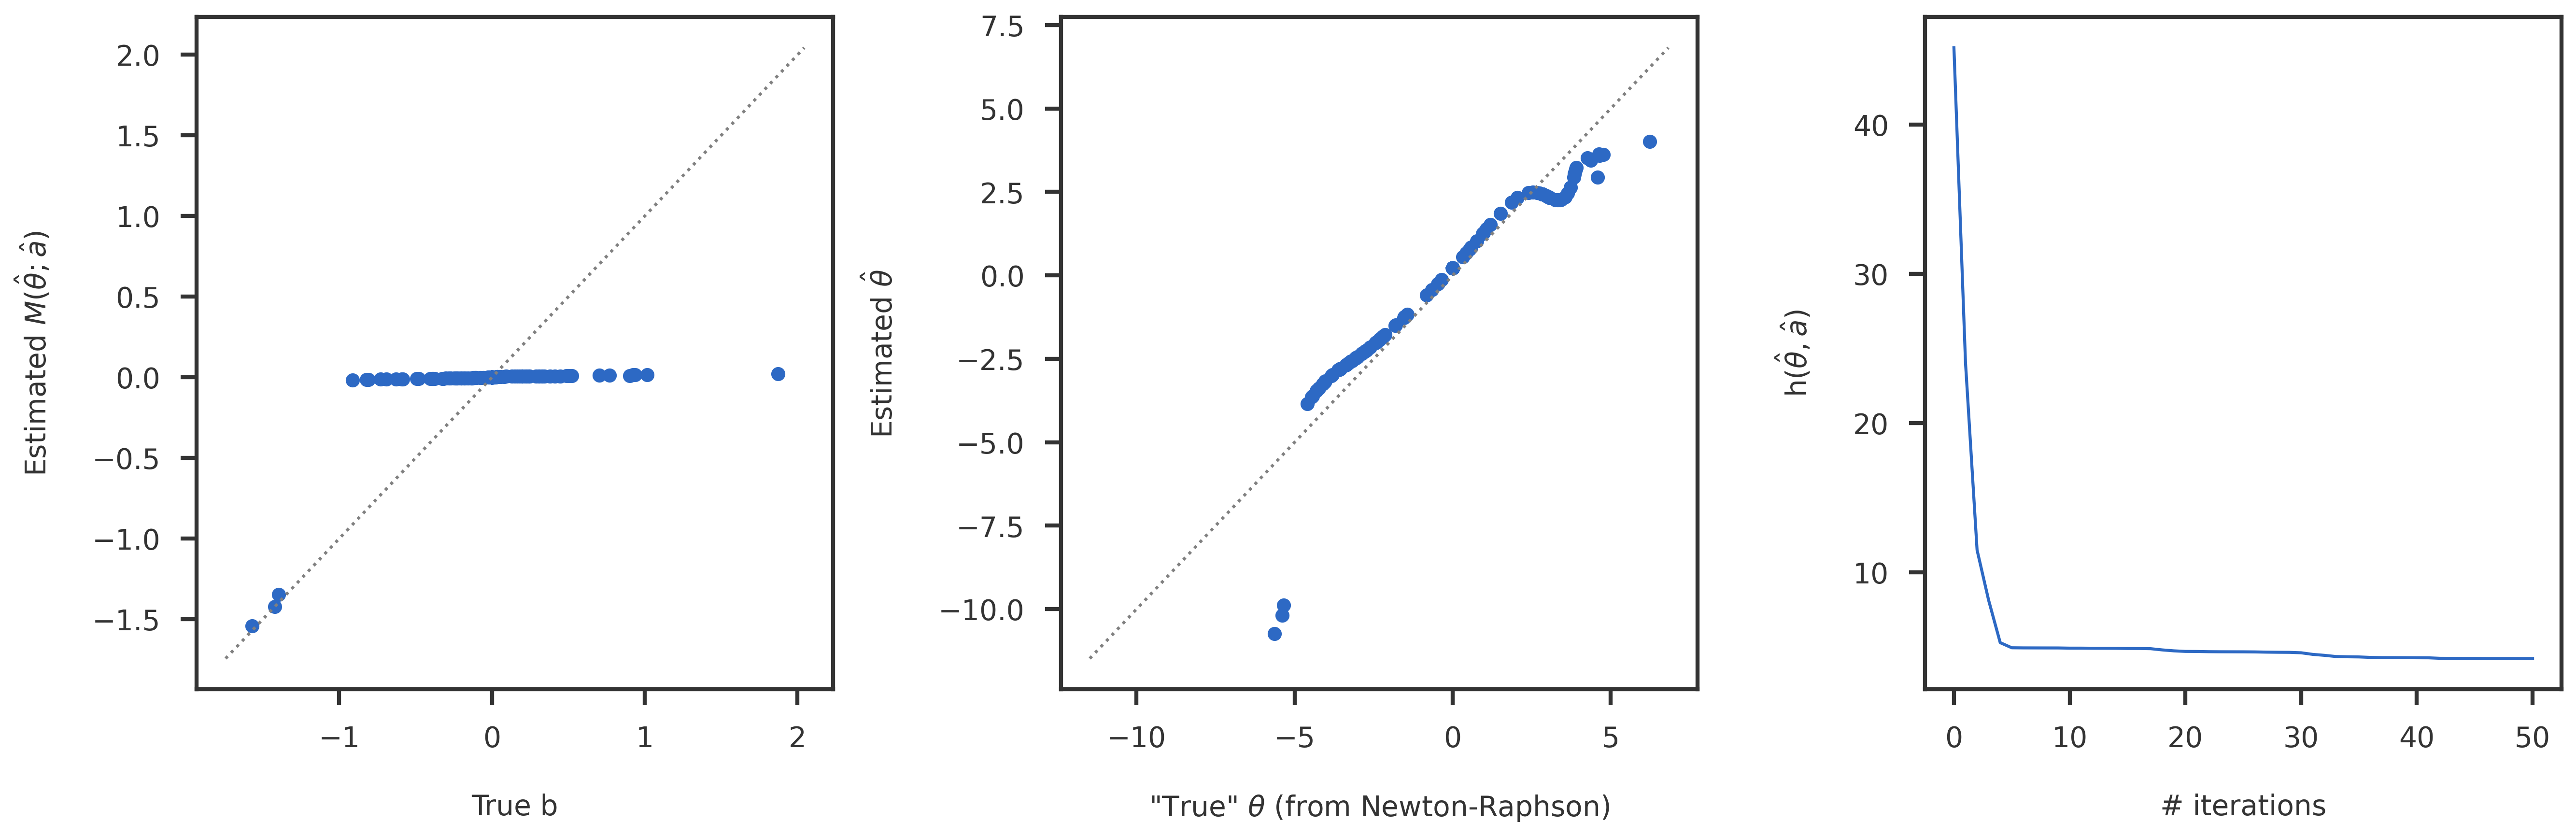

In [5]:
z_cg = cg_min.x[:p]
a_cg = cg_min.x[2*p:]
w_cg = softmax(a_cg, base = softmax_base)
lj_cg = cg_min.x[p:2*p]
print ("True w:", wtrue)
print("Est. w: ", w_cg)
print("Est. Lagrangian (for non-zero b): ")
print(lj_cg[btrue!=0])

b_cg = shrink_theta(z_cg, strue, w_cg, sk, dj)
fig = plt.figure(figsize = (18,6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.scatter(btrue, b_cg)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel("True b")
ax1.set_ylabel(r"Estimated $M(\hat{\theta}; \hat{a})$")

ax2.scatter(ztrue, z_cg)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel(r'''"True" $\theta$ (from Newton-Raphson)''')
ax2.set_ylabel(r'''Estimated $\hat{\theta}$''')

niter   = cg_min.nit
allobjs = np.zeros(niter + 1)
for i, params in enumerate(cg_min.allvecs):
    z_it = params[:p]
    a_it = params[2*p:]
    lj_it = params[p:2*p]
    w_it = softmax(a_it, base = softmax_base)
    #alllagrangian[i] = penalty_operator_lagrangian(z_it, w_it, strue, sk, dj, lj_it, btrue)
    allobjs[i] = objective_numeric_lagrangian(params, strue, sk, dj, btrue, p, k, softmax_base)
ax3.plot(np.arange(niter + 1), allobjs)
ax3.set_xlabel("# iterations")
ax3.set_ylabel(r"h($\hat{\theta}, \hat{a}$)")

plt.tight_layout()
plt.show()

In [6]:
akinit

array([-0.22314354, -2.70805005, -2.70805005, -2.70805005])

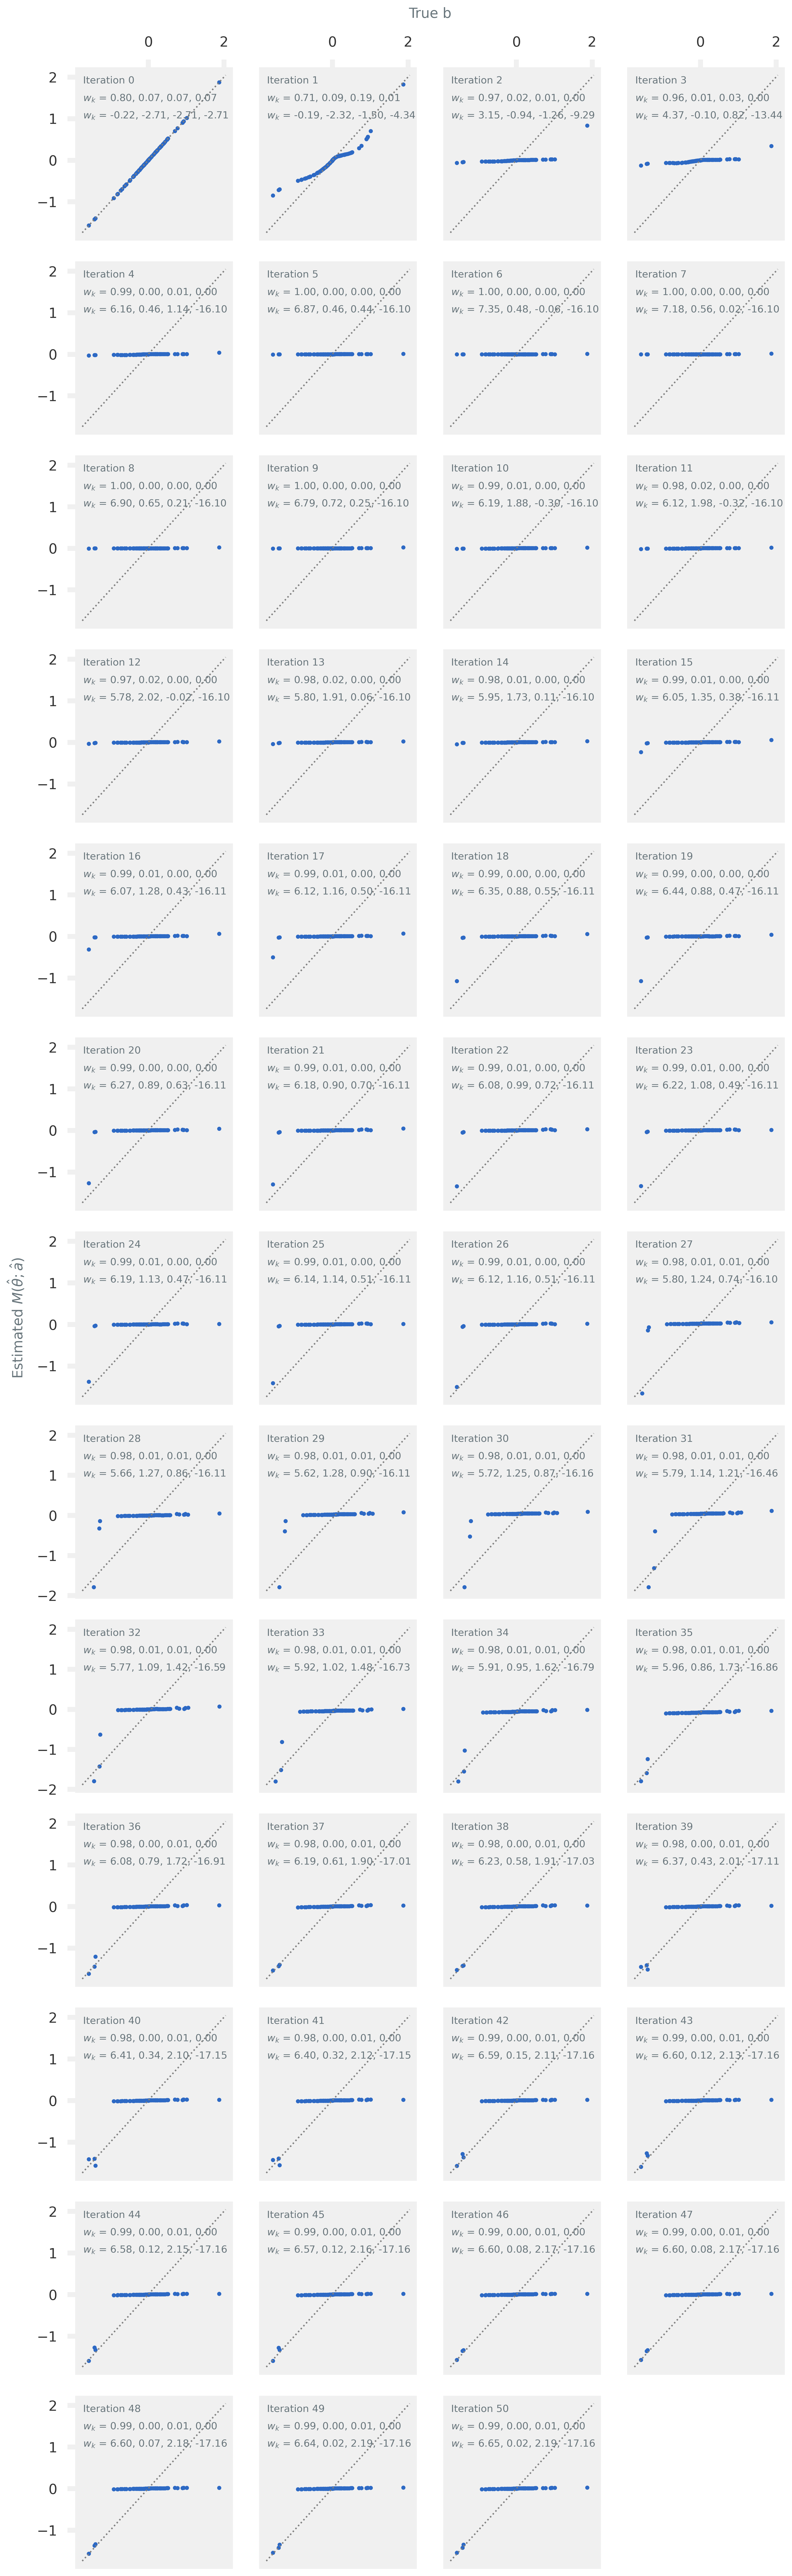

In [7]:
subplot_h = 1.8
nstep = 1
nplot = int(niter / nstep) + 1
ncol  = 4
nrow  = int(nplot / ncol + 1) if nplot%ncol != 0 else int(nplot / ncol)
figw  = ncol * subplot_h + (ncol - 1) * 0.3 + 1.2
figh  = nrow * subplot_h + (nrow - 1) * 0.3 + 1.5
figscale = 12.0 / figw

bgcolor = '#F0F0F0'
highlight_color = '#EE6868'
subdue_color = '#848f94'
text_color = '#69767c'

fig = plt.figure(figsize = (figw * figscale, figh * figscale))
axmain = fig.add_subplot(111)

for i in range(nplot):
    ax  = fig.add_subplot(nrow, ncol, i + 1)
    itr = i * nstep
    
    params = cg_min.allvecs[itr]
    z_it = params[:p]
    a_it = params[2*p:]
    #lj_it = params[p:2*p]
    w_it = softmax(a_it, base = softmax_base)
    b_it = shrink_theta(z_it, strue, w_it, sk, dj)
    
    ax.scatter(btrue, b_it, s=10)
    mpl_utils.plot_diag(ax)
    
    wtext = r'$w_k$ = ' + ', '.join([f"{w:.2f}" for w in w_it])
    atext = r'$w_k$ = ' + ', '.join([f"{a:.2f}" for a in a_it])
    itrtext = f"Iteration {itr}"

    ax.text(0.05, 0.95, itrtext, va='top', ha='left', 
            transform=ax.transAxes, color = text_color, fontsize = 10)
    ax.text(0.05, 0.85, wtext, va='top', ha='left', 
            transform=ax.transAxes, color = text_color, fontsize = 10)
    ax.text(0.05, 0.75, atext, va='top', ha='left', 
            transform=ax.transAxes, color = text_color, fontsize = 10)
    ax.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
    
    ax.set_facecolor(bgcolor)
    for side, border in ax.spines.items():
        border.set_visible(False)
    if i < ncol:
        ax.tick_params(top = True, labeltop = True, color = bgcolor, width = 5)
        #ax.set_xticks(np.log10([0.001, 0.01, 0.1, 1.0]))
    if i%ncol == 0:
        ax.tick_params(left = True, labelleft = True, color = bgcolor, width = 5)
    #ax.set_ylim(-0.1, 2.1)
    
axmain.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
for side, border in axmain.spines.items():
    border.set_visible(False)

axmain.set_xlabel("True b", labelpad = 50, color = text_color)
axmain.set_ylabel(r"Estimated $M(\hat{\theta}; \hat{a})$", labelpad = 50, color = text_color)
axmain.xaxis.set_label_position('top') 


plt.tight_layout()
# plt.savefig(f'../plots/{fileprefix}.pdf', bbox_inches='tight')
# plt.savefig(f'../plots/{fileprefix}.png', bbox_inches='tight')
plt.show()

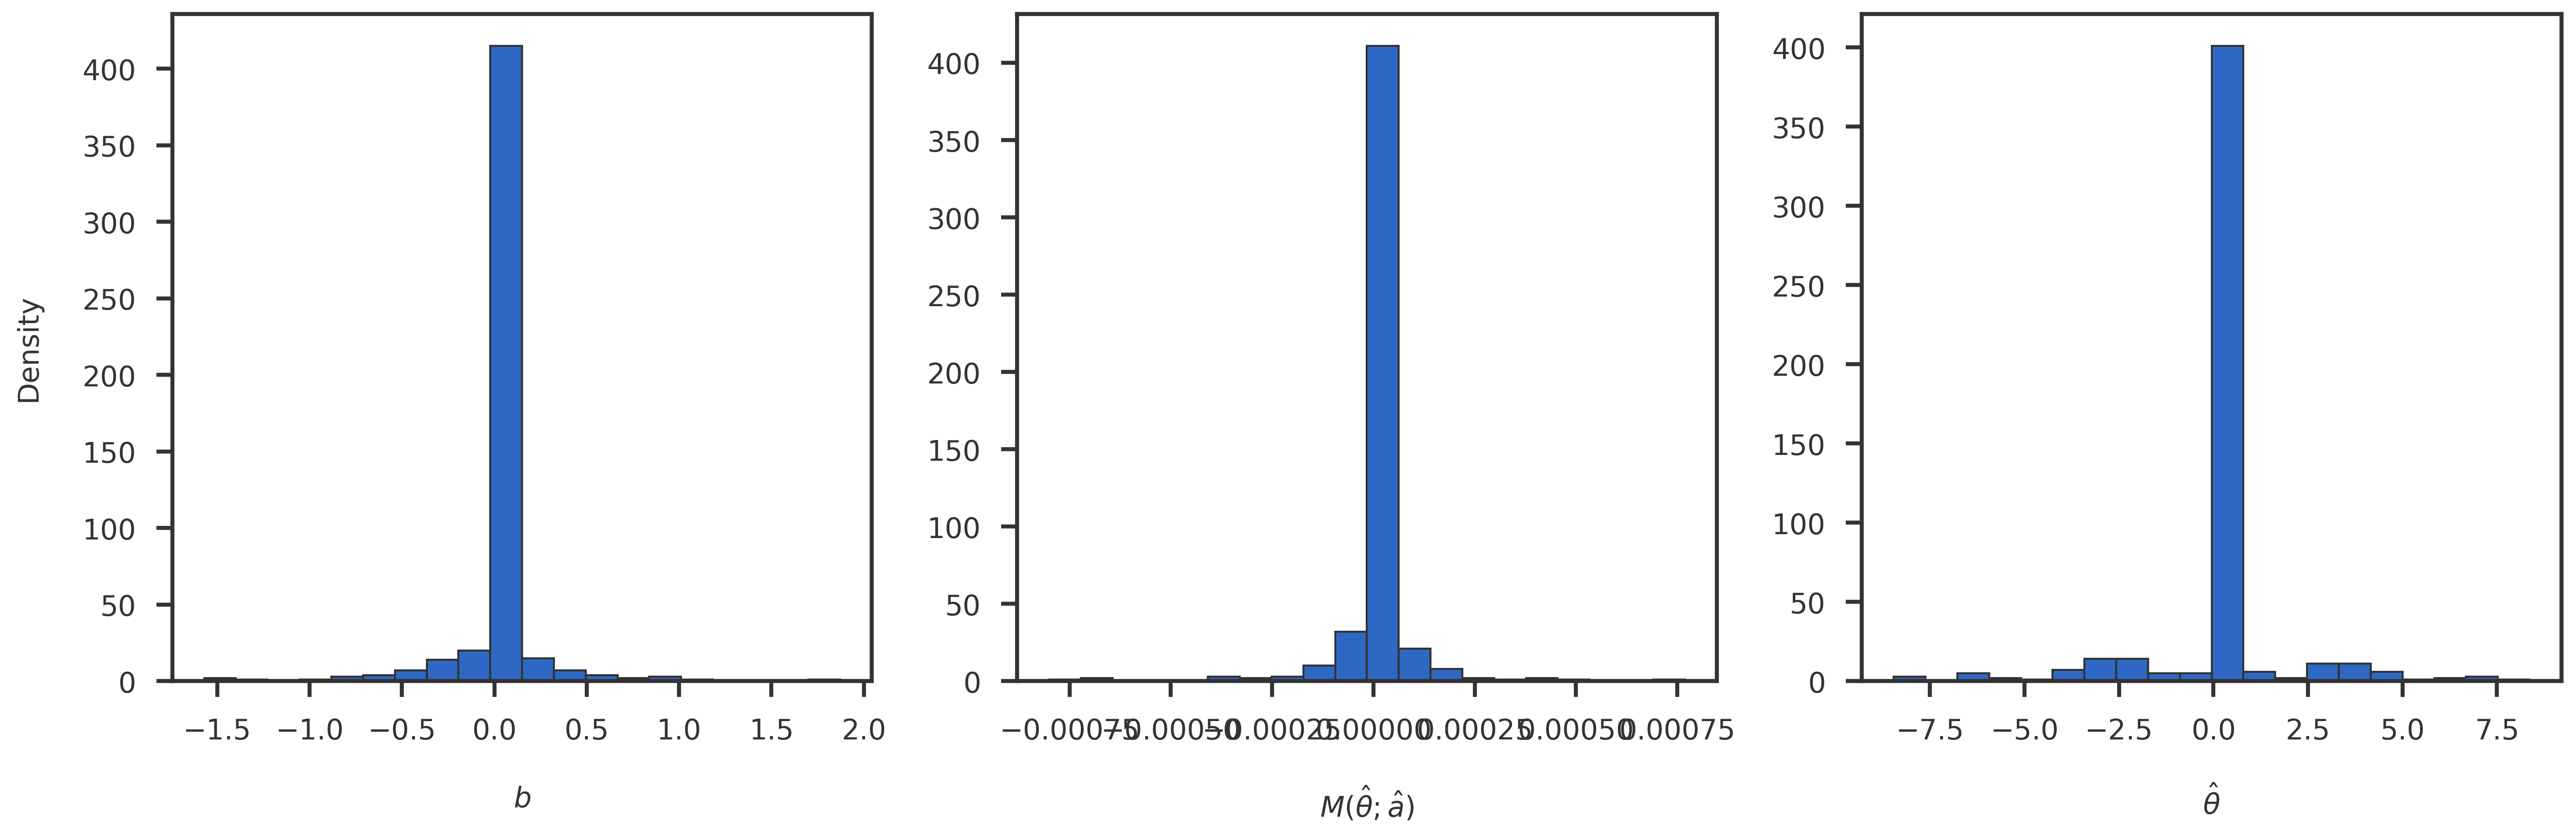

In [374]:
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.hist(btrue, density = False)
ax2.hist(b_cg, density = False)
ax3.hist(z_cg, density = False)

ax1.set_xlabel(r"$b$")
ax2.set_xlabel(r"$M(\hat{\theta}; \hat{a})$")
ax3.set_xlabel(r"$\hat{\theta}$")
ax1.set_ylabel("Density")

#for ax in [ax1, ax2, ax3]:
#    ax.set_ylim([0, 100])

plt.tight_layout()
plt.show()

In [375]:
def get_wk_text(wk, idx = None, fmt="%.3f"):
    wlist = wk.copy() if idx is None else [wk[i] for i in idx]
    wstr  = ", ".join([fmt%w for w in wlist])
    return f"({wstr})"

atrue = np.log(wtrue + 1e-8) / np.log(softmax_base)
print ("True w and a:")
print(get_wk_text(wtrue))
print(get_wk_text(atrue))
print()
print ("Estimated w and a:")
print(get_wk_text(w_cg))
print(get_wk_text(a_cg))

True w and a:
(0.800, 0.067, 0.067, 0.067)
(-0.223, -2.708, -2.708, -2.708)

Estimated w and a:
(0.999, 0.001, 0.000, 0.000)
(9.076, 1.951, -9.061, -15.704)


In [388]:
nseq = 100

a0seq = np.linspace(-10, 10, nseq)
a1seq = np.linspace(-10, 10, nseq)
a_grid   = np.stack(np.meshgrid(a0seq, a1seq))

a_2col = a_grid.reshape(2, -1).T
print(a_2col.shape)

aidx = np.array([0, 2])
h_grid = np.zeros(a_2col.shape[0])
w_2col = np.zeros((a_2col.shape[0], 2))
for i in range(a_2col.shape[0]):
    ak = atrue.copy()
    ak[aidx] = a_2col[i, :]
    wk = softmax(ak)
    new_lgrng = np.ones(btrue.shape[0]) * 5.0
    params = np.concatenate([ztrue, new_lgrng, ak])
    h_grid[i] = objective_numeric_lagrangian(params, strue, sk, dj, btrue, p, k, softmax_base)
    #h_grid[i] = penalty_operator_lagrangian(ztrue, wk, strue, sk, dj, lgrng, btrue)
    w_2col[i, :] = wk[aidx]
    #print(i, get_wk_text(ak), h_grid[i])
w_grid = w_2col.T.reshape(2, nseq, nseq)

(10000, 2)


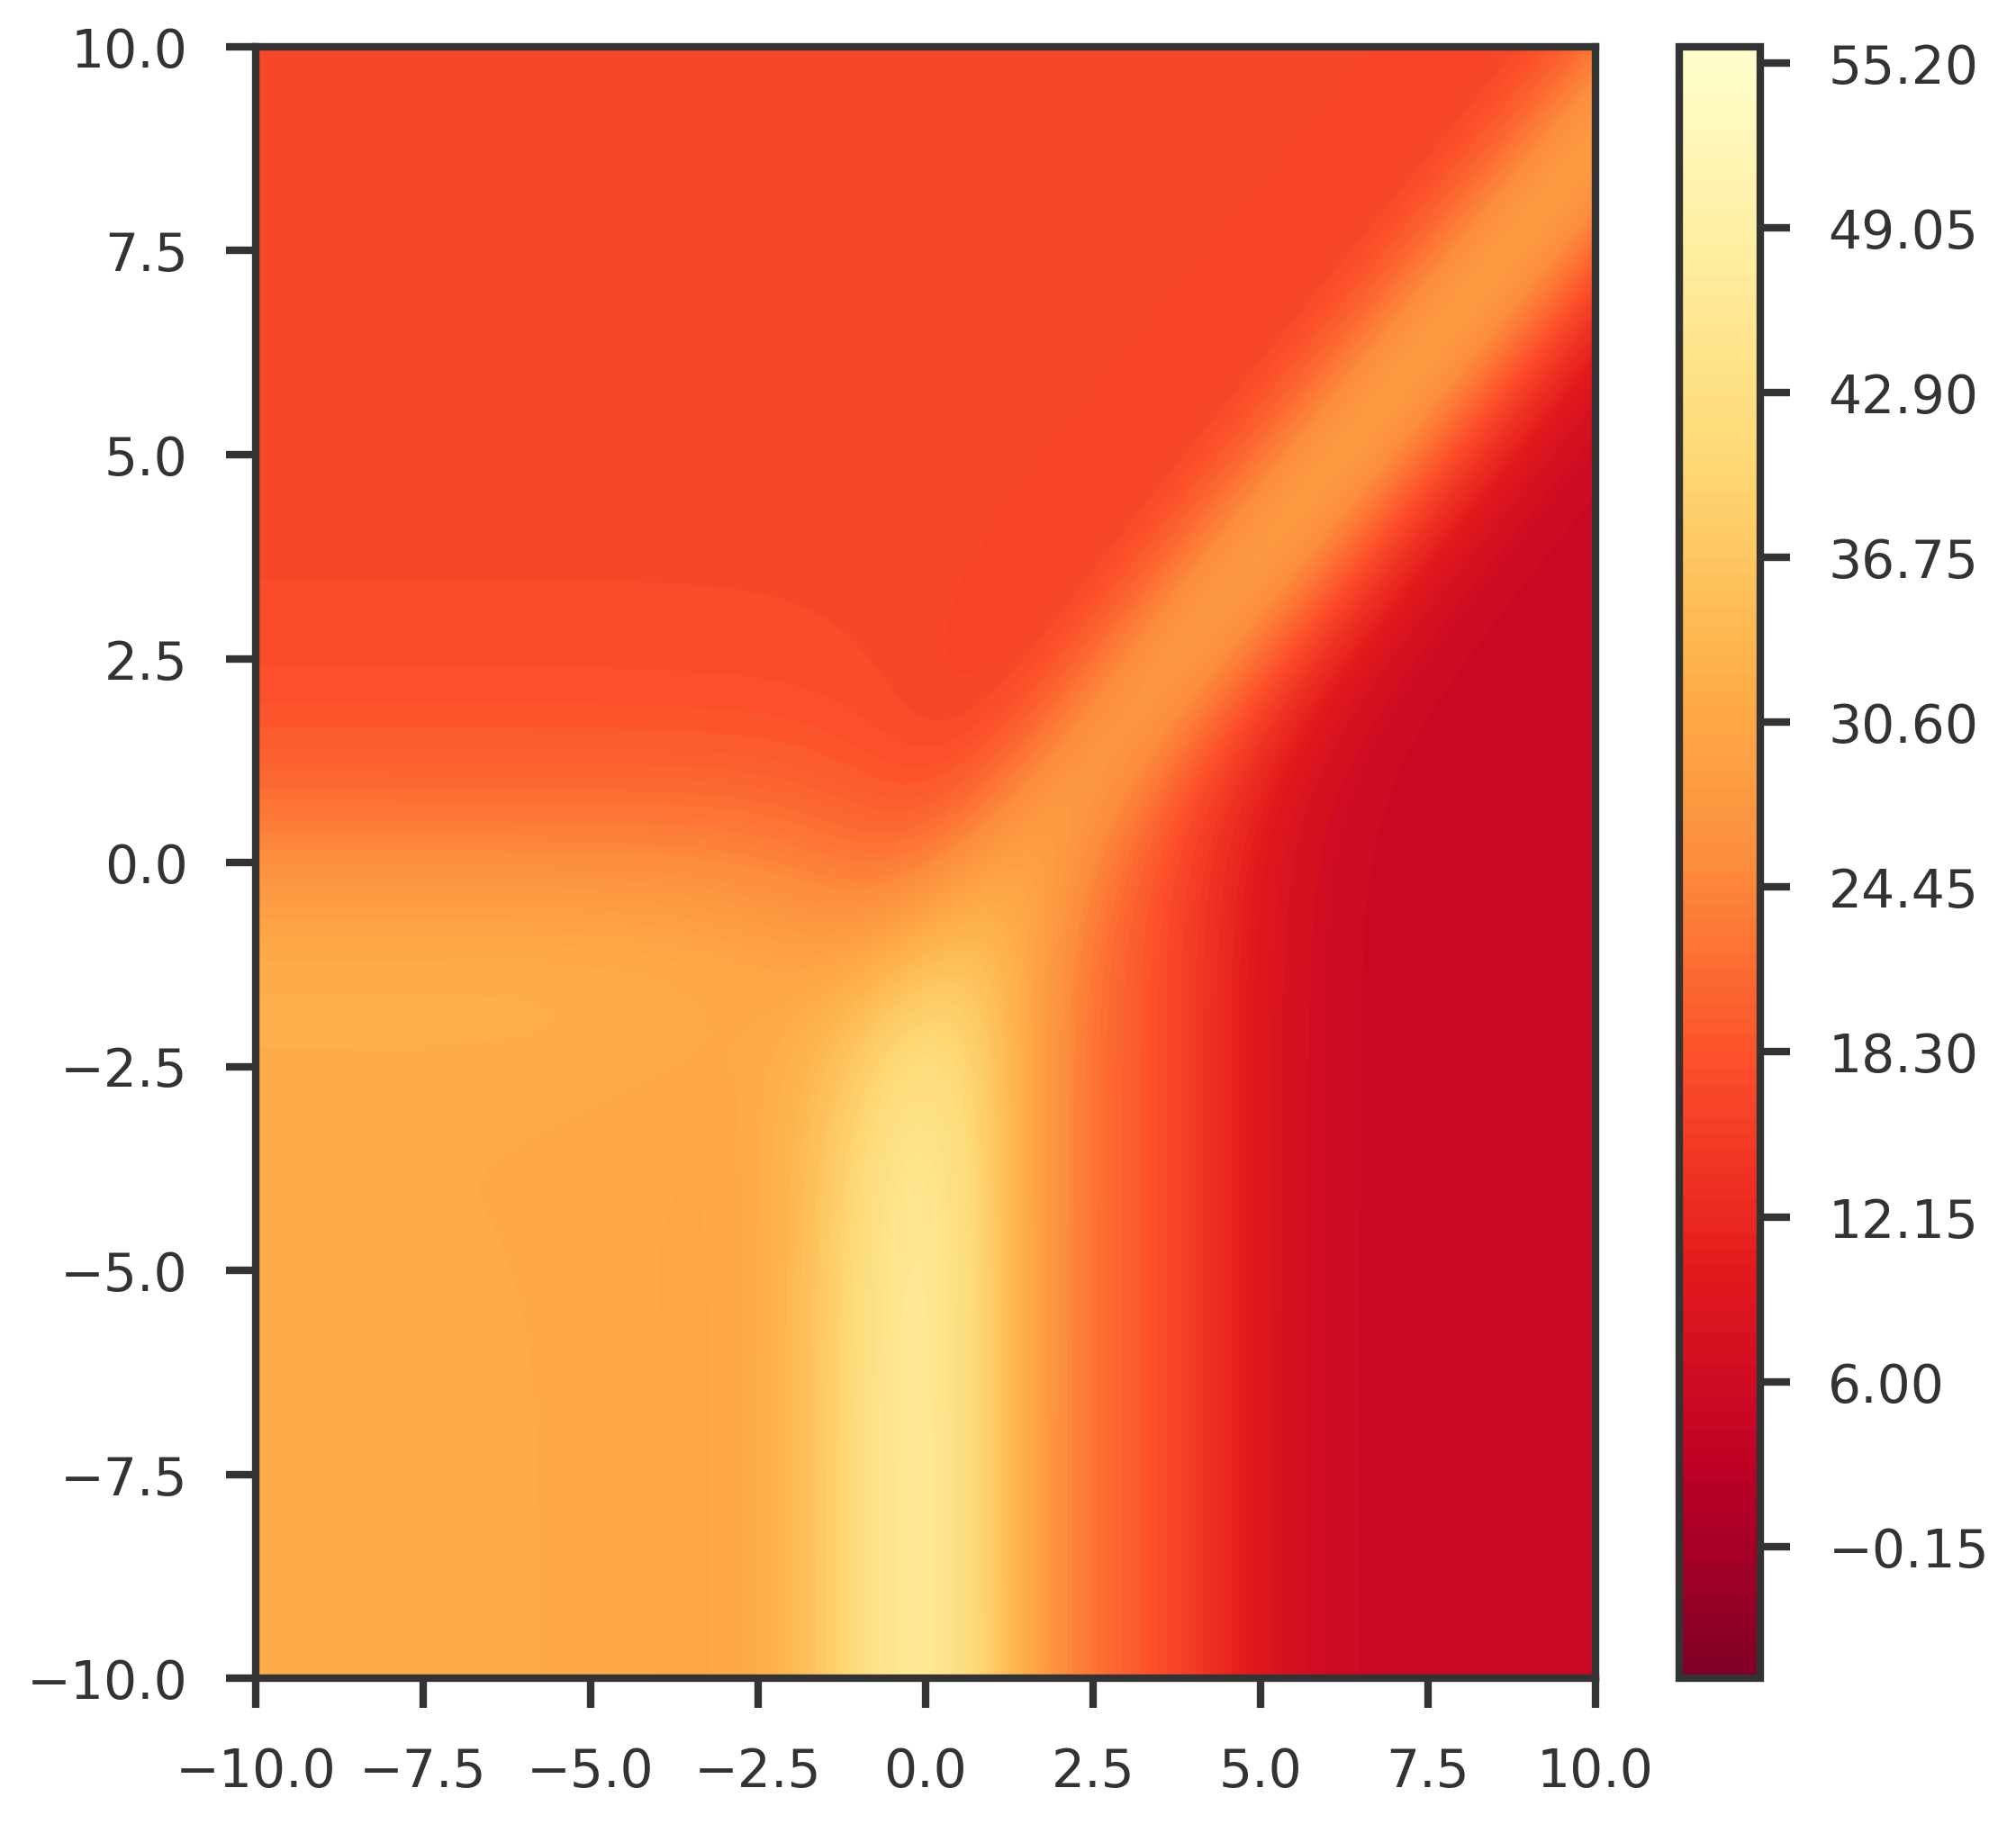

In [389]:
from matplotlib import cm

fig = plt.figure()
ax1 = fig.add_subplot(111)
xx, yy = a_grid
zz = h_grid.reshape(nseq, nseq)

zmin = np.min(zz) - 1 * np.std(zz)
zmax = np.max(zz) + 1 * np.std(zz)
levels = np.linspace(zmin, zmax, 100)
cmap = cm.YlOrRd_r

eps = 1e-8
cset = ax1.contourf(xx, yy, zz, levels, cmap = cmap)
#ax1.clabel(cset, inline=True, fontsize=10)

fig.colorbar(cset)
plt.show()

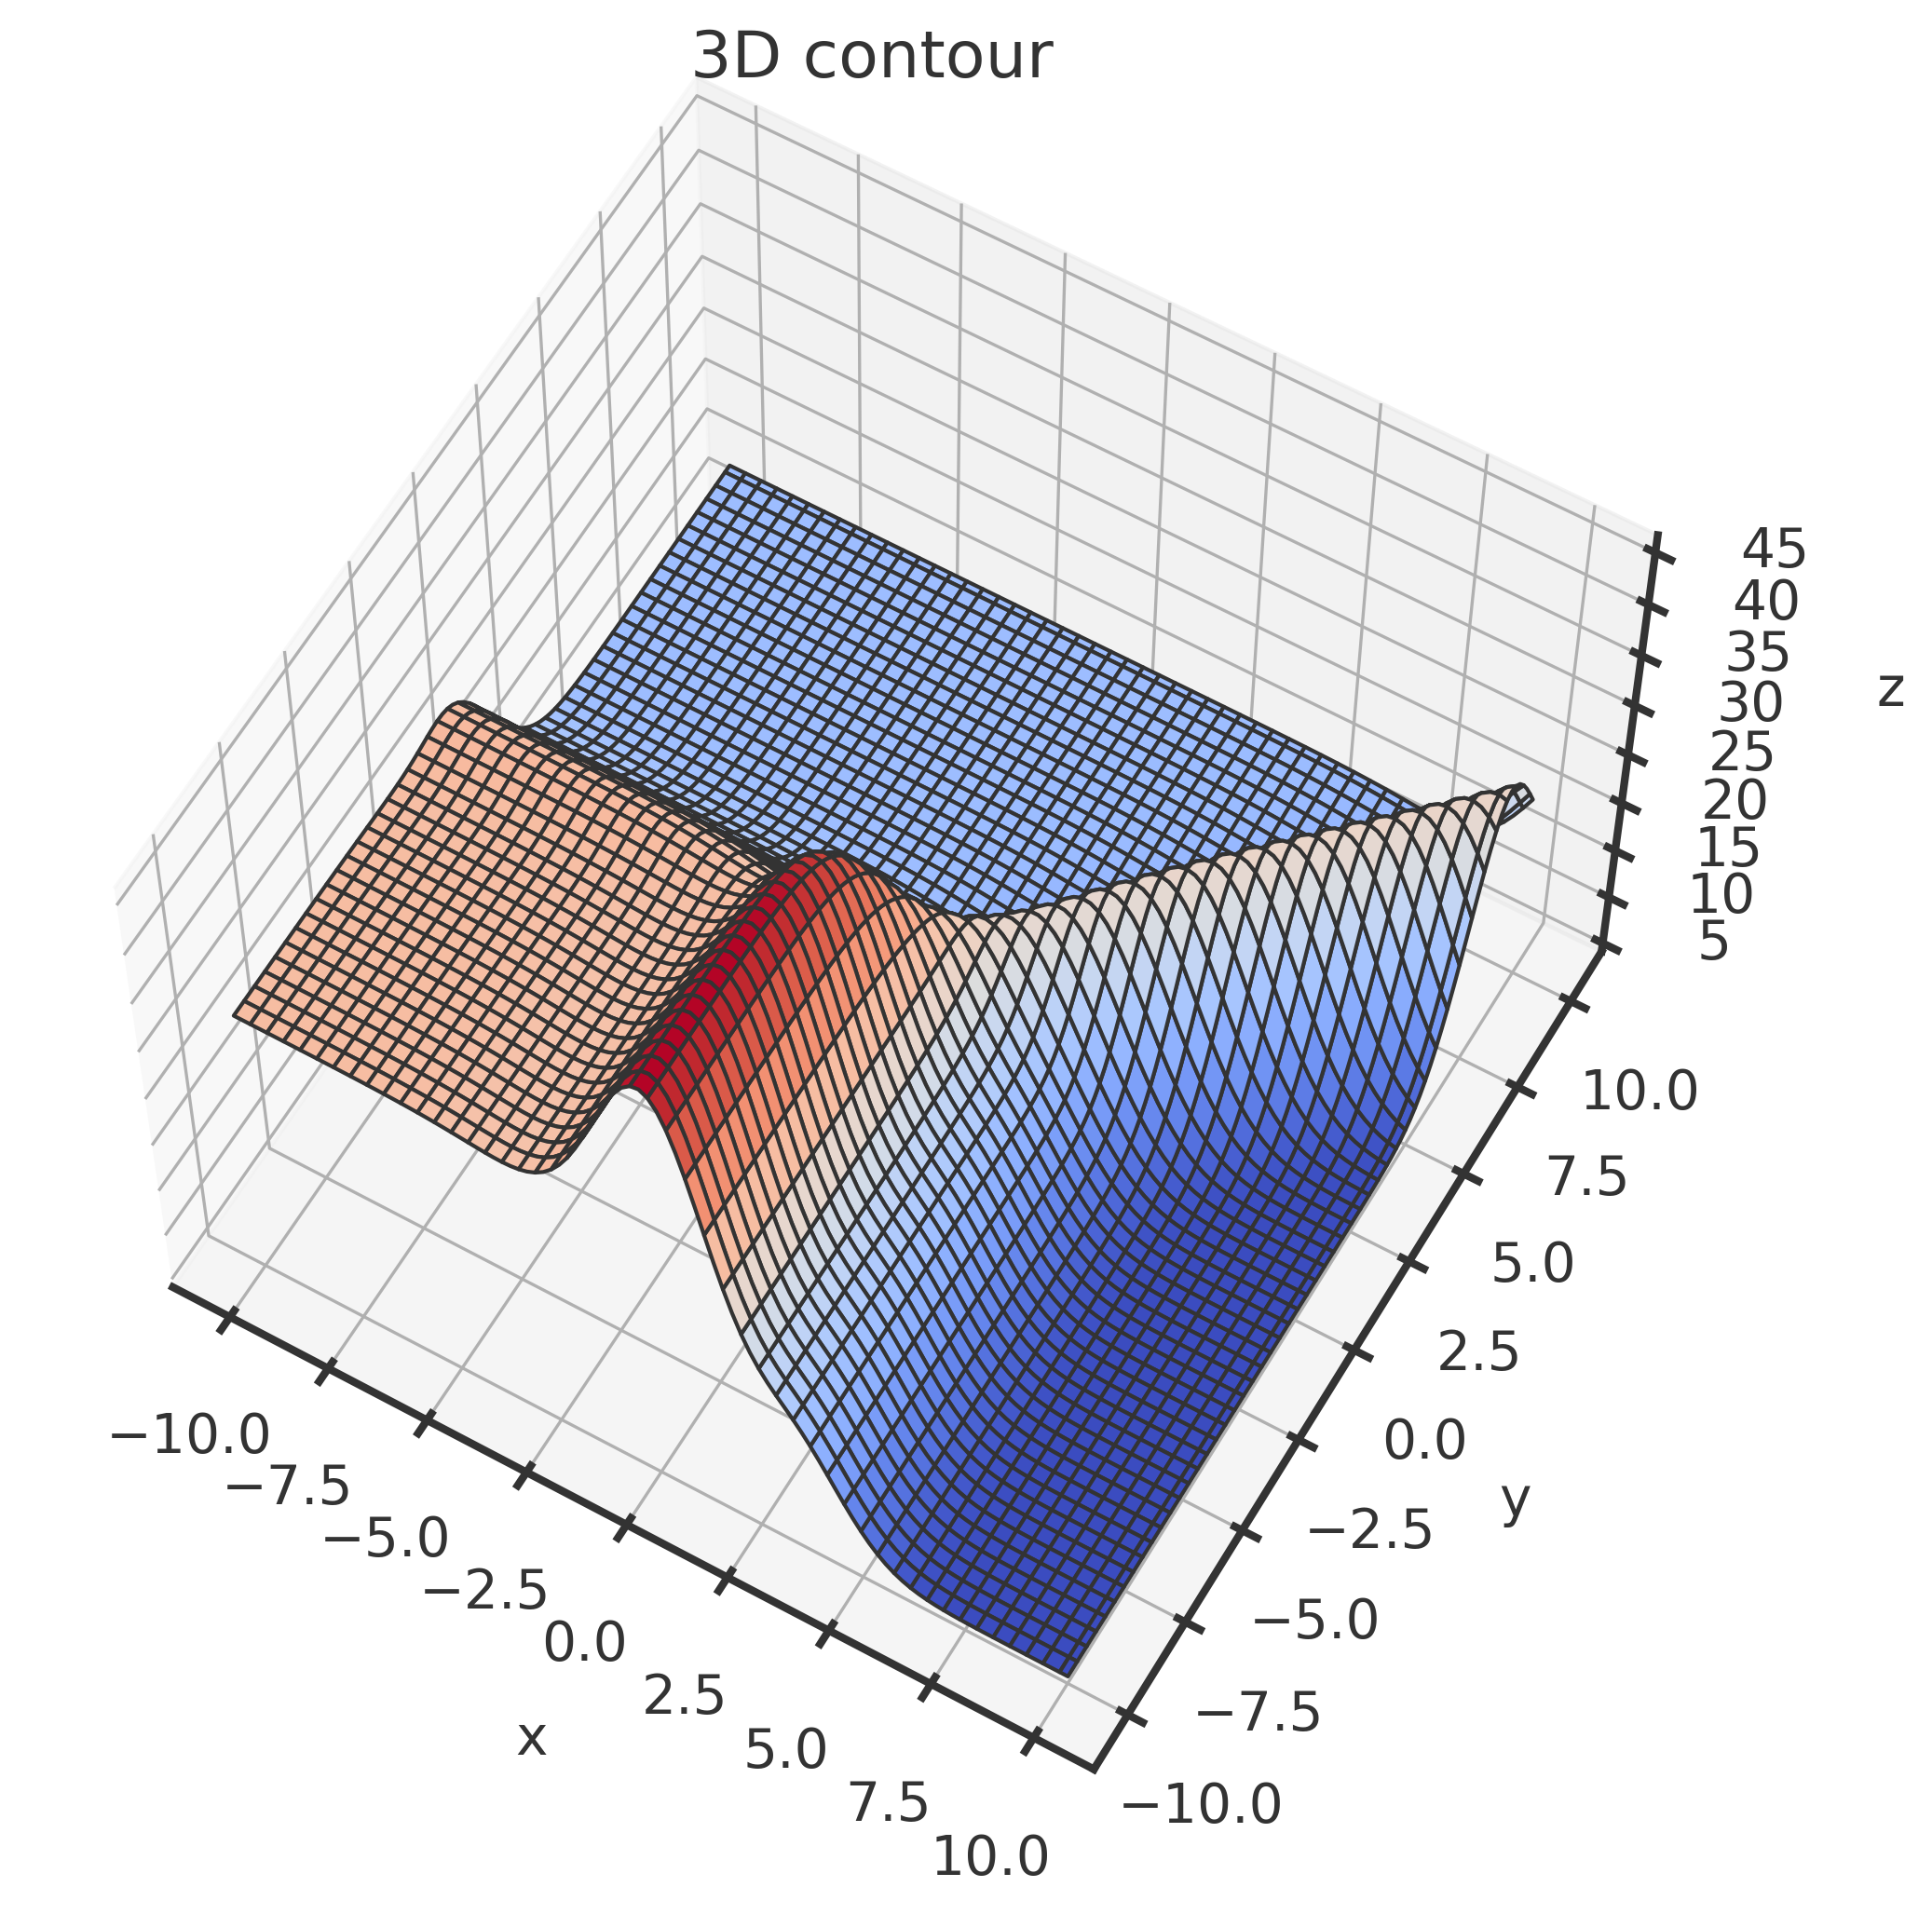

In [390]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d', azim=-60, elev=60)

surf1 = ax.plot_surface(xx, yy, zz, cmap=cm.coolwarm)
# ax.contour3D(xx, yy, zz, 50, cmap=cm.YlOrRd_r)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('3D contour')
plt.show()

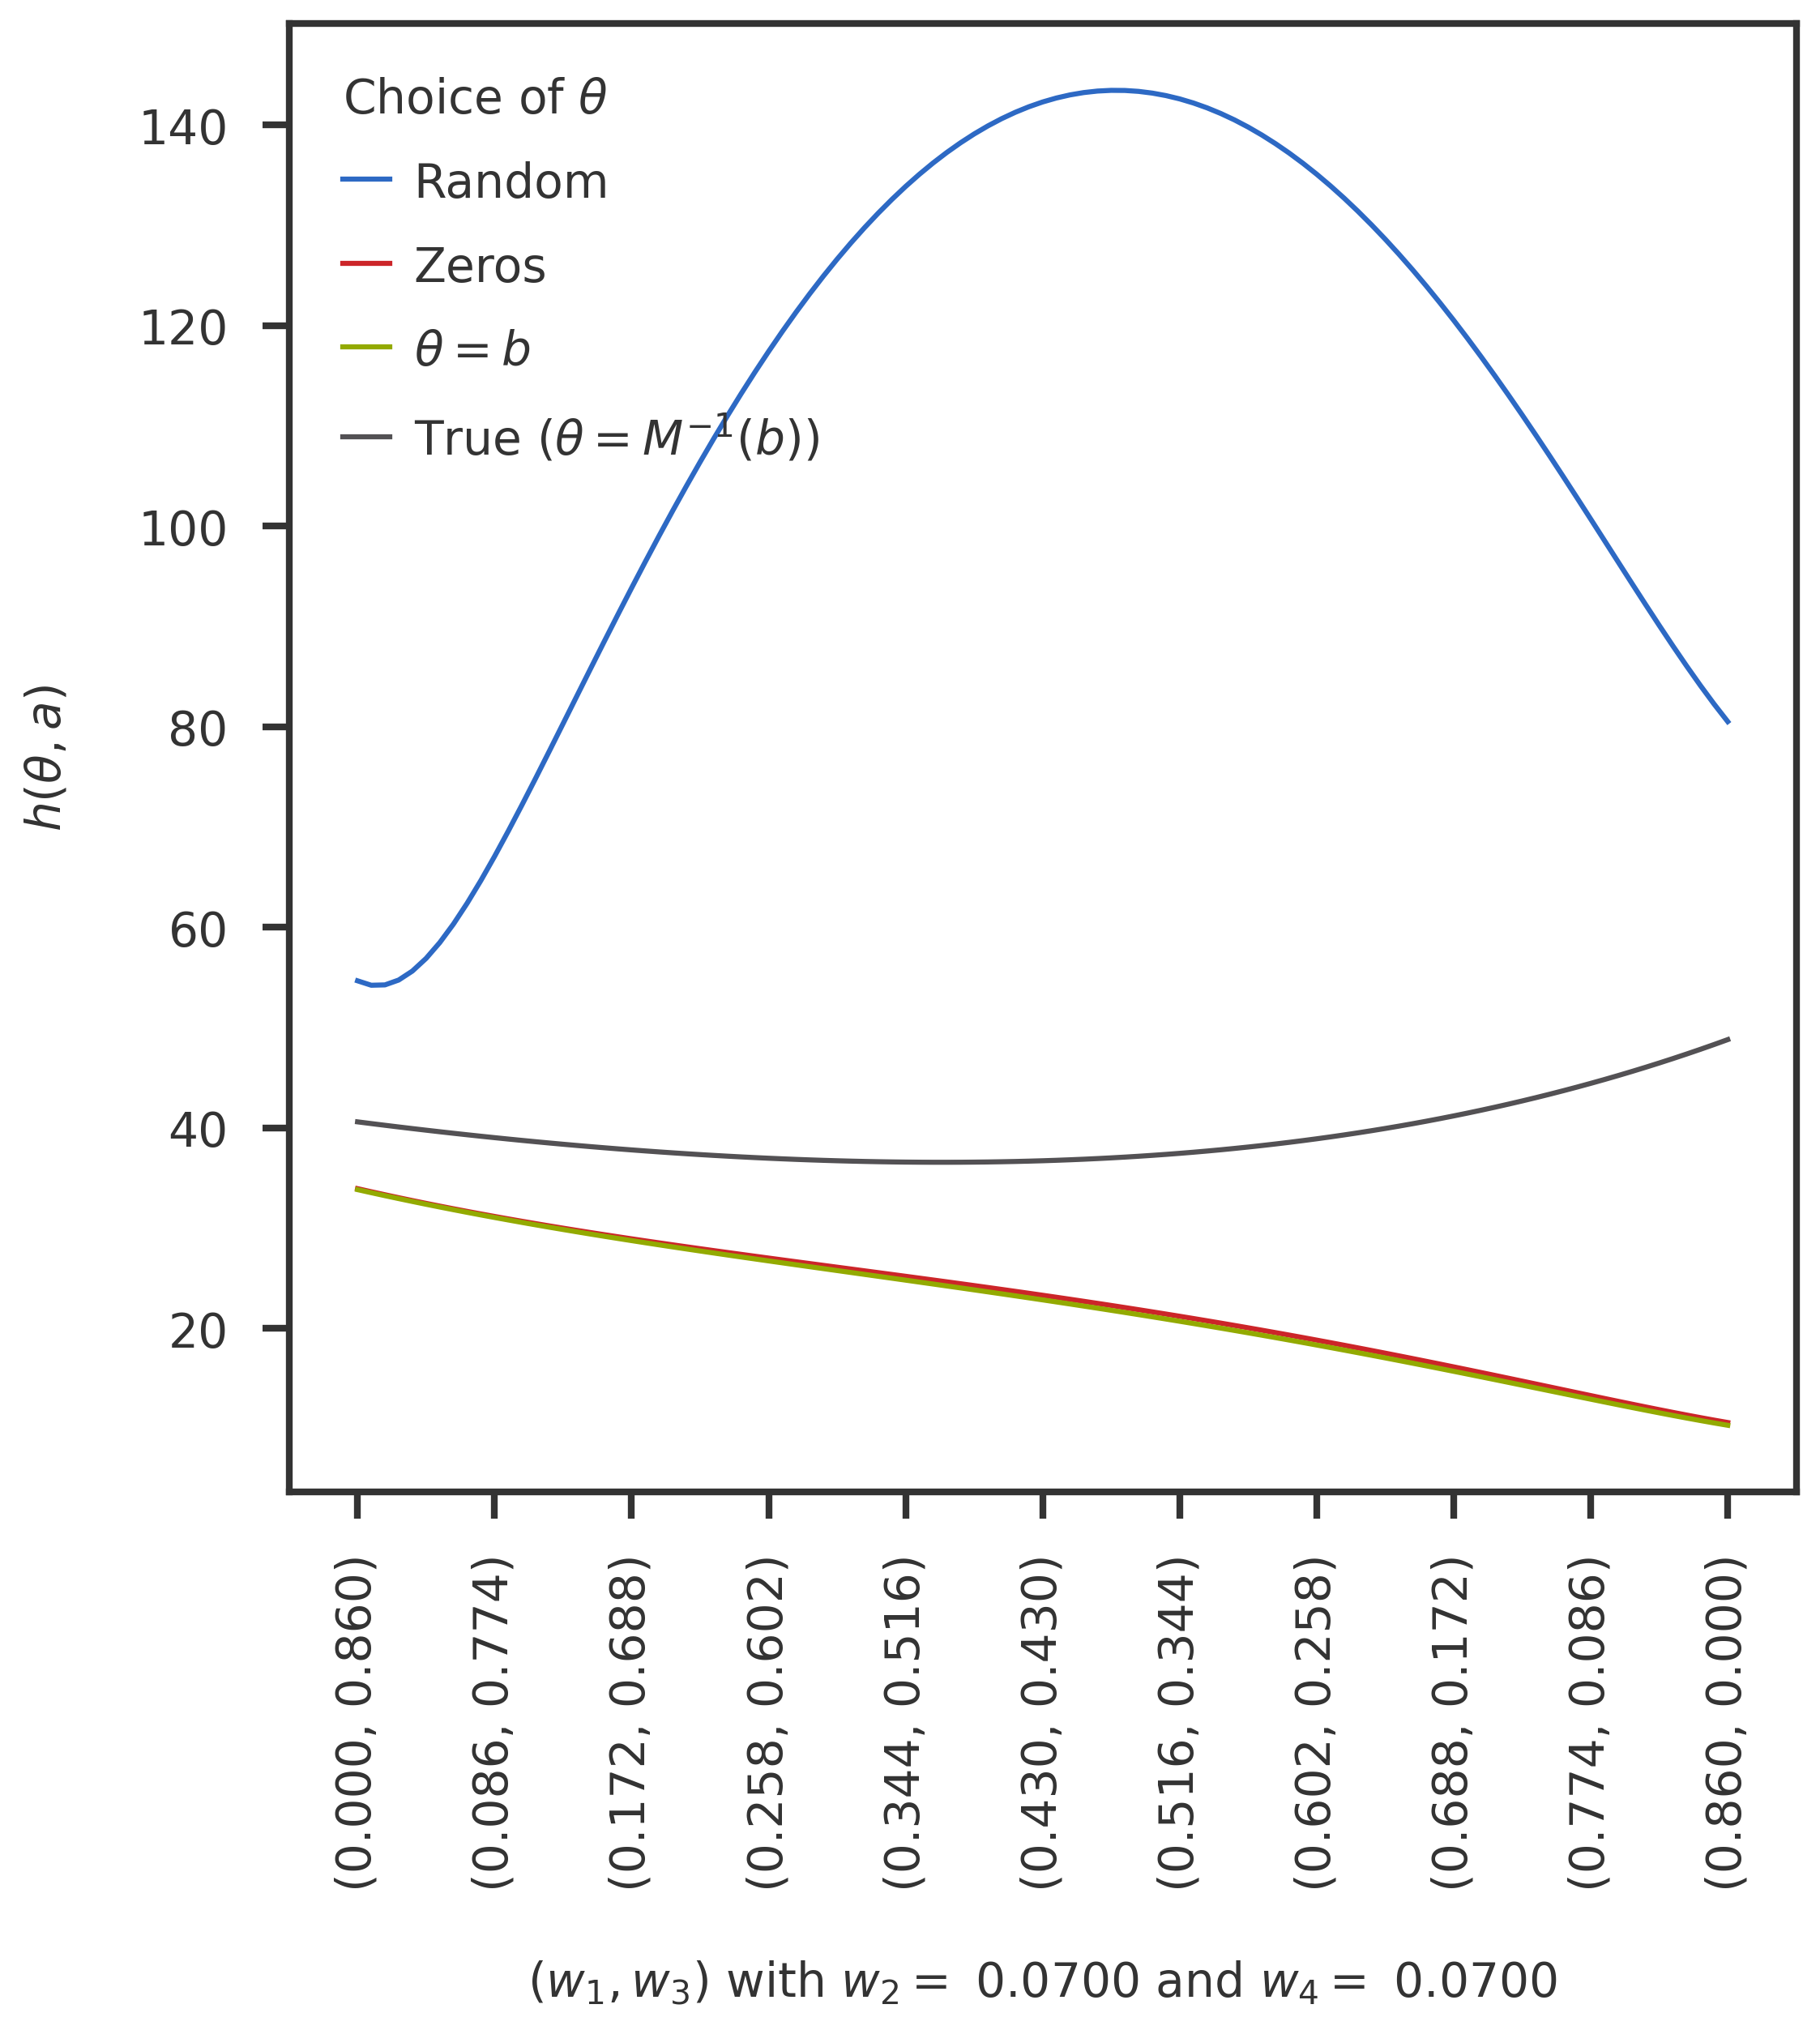

In [394]:
#collapse-hide

def get_obj_list(aseq, z, std, sk, dj, b, p, k, softmax_base):
    h_seq = list()
    lgrng = np.ones(btrue.shape[0]) * 10.0
    for ak in aseq:
        params = np.concatenate([z, lgrng, ak])
        h = objective_numeric_lagrangian(params, strue, sk, dj, btrue, p, k, softmax_base)
        h_seq.append(h)
    return np.array(h_seq)


nseq  = 101
w2 = w4 = 0.07
w1seq = np.linspace(0, 1 - w2 - w4, nseq)
w3seq = 1 - w2 - w4 - w1seq
w_seq = [np.array([w1, w2, w3, w4]) for w1, w3 in zip(w1seq, w3seq)]
a_seq = [np.log(w + 1e-8) / np.log(softmax_base) for w in w_seq]
w_seq = [softmax(ak, base = softmax_base) for ak in a_seq]

h_seq_random = get_obj_list(a_seq, np.random.rand(p), strue, sk, dj, btrue, p, k, softmax_base)
h_seq_zeros  = get_obj_list(a_seq, np.zeros(p), strue, sk, dj, btrue, p, k, softmax_base)
h_seq_btrue  = get_obj_list(a_seq, btrue, strue, sk, dj, btrue, p, k, softmax_base)
h_seq_ttrue  = get_obj_list(a_seq, ztrue, strue, sk, dj, btrue, p, k, softmax_base)
    
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(nseq), h_seq_random, label = r"Random")
ax1.plot(np.arange(nseq), h_seq_zeros,  label = r"Zeros")
ax1.plot(np.arange(nseq), h_seq_btrue,  label = r"$\theta = b$")
ax1.plot(np.arange(nseq), h_seq_ttrue,  label = r"True ($\theta = M^{-1}(b)$)")

legendtitle = r"Choice of $\theta$"
legend1 = ax1.legend(loc = 'upper left', bbox_to_anchor = (0.02, 0.98), frameon = False, title = legendtitle)
legend1._legend_box.align = "left"
#lframe = legend1.get_frame()
#lframe.set_linewidth(0)

#ax1.hist(mean)
#ax1.legend()
ax1.set_ylabel(r"$h(\theta, a)$")
ax1.set_xlabel(r"($w_1, w_3$) with $w_2 =$ " + f"{w2:.4f}" + r" and $w_4 =$ " + f"{w4:.4f}")


xtickpos = np.arange(0, nseq, 10)
xticklabels = [get_wk_text(w_seq[i], idx = [0, 2]) for i in xtickpos]
ax1.set_xticks(xtickpos)
ax1.set_xticklabels(xticklabels, rotation = 90)

plt.show()